## Viz Categorical with Periodogram

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from statsmodels.tsa.deterministic import (CalendarFourier,
                                           CalendarSeasonality,
                                           CalendarTimeTrend,
                                           DeterministicProcess)
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm

In [7]:
DIRECTORY = './data/'
calendar = pd.read_csv(DIRECTORY + 'calendar.csv', parse_dates=['date'])
inventory = pd.read_csv(DIRECTORY + 'inventory.csv')
test = pd.read_csv(DIRECTORY + 'sales_test.csv', parse_dates=['date'])
train = pd.read_csv(DIRECTORY + 'sales_train.csv', parse_dates=['date'])
solution = pd.read_csv(DIRECTORY + 'solution.csv')
test_weights = pd.read_csv(DIRECTORY + 'test_weights.csv')

In [8]:
inventory['name_first'] = inventory['name'].str.split('_').str[0]
inventory.head()

,unique_id,product_unique_id,name,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,warehouse,name_first
0,5255,2583,Pastry_196,Bakery,Bakery_L2_14,Bakery_L3_26,Bakery_L4_1,Prague_3,Pastry
1,4948,2426,Herb_19,Fruit and vegetable,Fruit and vegetable_L2_30,Fruit and vegetable_L3_86,Fruit and vegetable_L4_1,Prague_3,Herb
2,2146,1079,Beet_2,Fruit and vegetable,Fruit and vegetable_L2_3,Fruit and vegetable_L3_65,Fruit and vegetable_L4_34,Prague_1,Beet
3,501,260,Chicken_13,Meat and fish,Meat and fish_L2_13,Meat and fish_L3_27,Meat and fish_L4_5,Prague_1,Chicken
4,4461,2197,Chicory_1,Fruit and vegetable,Fruit and vegetable_L2_17,Fruit and vegetable_L3_33,Fruit and vegetable_L4_1,Frankfurt_1,Chicory


In [9]:
# Anytree
from anytree import Node, RenderTree
from anytree.exporter import DotExporter

root = Node("Products")
nodes = {"root": root}

for i, row in inventory[['L1_category_name_en', 'L2_category_name_en', 'L3_category_name_en', 'L4_category_name_en']].drop_duplicates().iterrows():
    level1 = row['L1_category_name_en']
    level2 = row['L2_category_name_en']
    level3 = row['L3_category_name_en']
    level4 = row['L4_category_name_en']

    if level1 not in nodes:
        nodes[level1] = Node(level1, parent=root)
    if level2 not in nodes:
        nodes[level2] = Node(level2, parent=nodes[level1])
    if level3 not in nodes:
        nodes[level3] = Node(level3, parent=nodes[level2])
    if level4 not in nodes:
        nodes[level4] = Node(level4, parent=nodes[level3])
        
for pre, _, node in RenderTree(root):
    print(f"{pre}{node.name}")

Products
├── Bakery
│   ├── Bakery_L2_14
│   │   ├── Bakery_L3_26
│   │   │   └── Bakery_L4_1
│   │   ├── Bakery_L3_76
│   │   ├── Bakery_L3_171
│   │   ├── Bakery_L3_37
│   │   ├── Bakery_L3_67
│   │   ├── Bakery_L3_69
│   │   ├── Bakery_L3_50
│   │   └── Bakery_L3_94
│   ├── Bakery_L2_18
│   │   ├── Bakery_L3_77
│   │   ├── Bakery_L3_83
│   │   ├── Bakery_L3_35
│   │   ├── Bakery_L3_110
│   │   ├── Bakery_L3_88
│   │   └── Bakery_L3_60
│   ├── Bakery_L2_9
│   │   ├── Bakery_L3_64
│   │   ├── Bakery_L3_16
│   │   │   ├── Bakery_L4_3
│   │   │   ├── Bakery_L4_40
│   │   │   ├── Bakery_L4_9
│   │   │   └── Bakery_L4_8
│   │   ├── Bakery_L3_75
│   │   │   ├── Bakery_L4_15
│   │   │   ├── Bakery_L4_30
│   │   │   └── Bakery_L4_55
│   │   ├── Bakery_L3_103
│   │   ├── Bakery_L3_104
│   │   └── Bakery_L3_146
│   ├── Bakery_L2_8
│   │   ├── Bakery_L3_41
│   │   ├── Bakery_L3_74
│   │   └── Bakery_L3_13
│   ├── Bakery_L2_28
│   │   ├── Bakery_L3_78
│   │   └── Bakery_L3_162
│   ├── Bakery_L2_

In [14]:
# Plotly Treemap
# Very good for hierarchical data

import plotly.express as px
# Ensure the data reflects the hierarchy (dropping duplicates if necessary)
cols = ['L3_category_name_en', 'name_first']
df_hierarchy = inventory[cols]

# Create an interactive treemap
fig = px.treemap(
    df_hierarchy,
    path=cols,
    title="Product Categories Hierarchy"
)
fig.show()

In [24]:
inventory[['L1_category_name_en', 'L2_category_name_en', 'L3_category_name_en', 'L4_category_name_en']].nunique()

L1_category_name_en      3
L2_category_name_en     47
L3_category_name_en    177
L4_category_name_en     68
dtype: int64

## Want to investigate non-nested relations, like name first vs. L3

In [36]:
import plotly.graph_objects as go

cols = ['L1_category_name_en', 'name_first']
flow_counts = inventory.groupby(cols).size().reset_index(name='count')
all_labels = pd.concat([flow_counts[cols[0]], flow_counts[cols[1]]]).unique().tolist()
label_to_index = {label: idx for idx, label in enumerate(all_labels)}

source = flow_counts[cols[0]].map(label_to_index).tolist()
target = flow_counts[cols[1]].map(label_to_index).tolist()
values = flow_counts['count'].tolist()

# fig = go.Figure(data=[go.Sankey(
#     node = dict(
#       pad = 15,
#       thickness = 20,
#       line = dict(color = "black", width = 0.5),
#       label = all_labels,
#       color = "blue"
#     ),
#     link = dict(
#       source = source,
#       target = target,
#       value = values,
#       color=["rgba(63, 81, 181, 0.8)"] * len(source)
#   ))])

# fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
# fig.show(config={'scrollZoom': True})

## Visualize which categories "contain" others using map counts

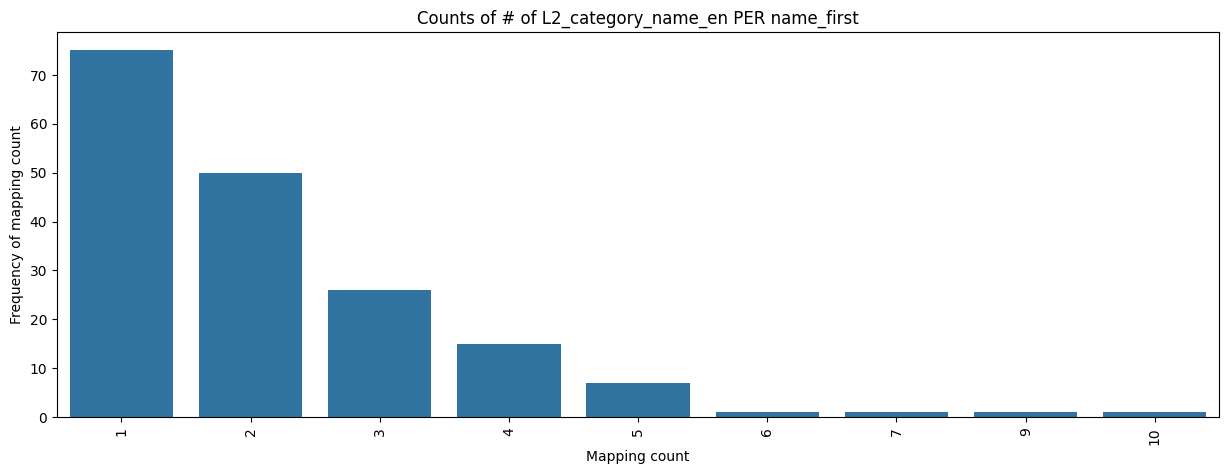

In [64]:

cols = ['name_first', 'L2_category_name_en']
# cols = ['L2_category_name_en', 'name_first']
col1 = cols[0]
col2 = cols[1]

fig = plt.figure(figsize=(15,5))
col1to2 = inventory.groupby(col1)[col2].nunique().value_counts() # for 
sns.barplot(x=col1to2.index, y=col1to2.values)
plt.title(f'Counts of # of {col2} PER {col1}')
plt.xlabel('Mapping count')
plt.ylabel('Frequency of mapping count')
plt.xticks(rotation=90);

In [ ]:
inventory.groupby(col1)[col2].nuniqusde().sort_values(ascending=False)

name_first
Snack         2
Plantain      1
Pappudia      1
Paprika       1
Parsley       1
             ..
Date          1
Decoration    1
Dessert       1
Donut         1
Zucchini      1
Name: L1_category_name_en, Length: 177, dtype: int64

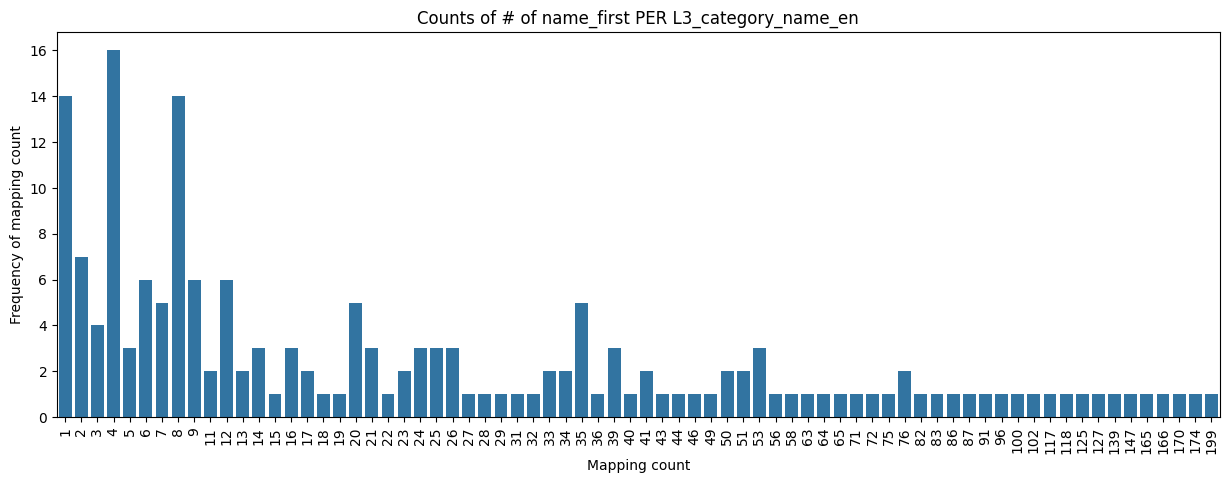

In [50]:
col2 = 'name_first'
col1 = 'L3_category_name_en'

fig = plt.figure(figsize=(15,5))
col1to2 = inventory.groupby(col1)[col2].count().value_counts() # for 
sns.barplot(x=col1to2.index, y=col1to2.values)
plt.title(f'Counts of # of {col2} PER {col1}')
plt.xlabel('Mapping count')
plt.ylabel('Frequency of mapping count')
plt.xticks(rotation=90);